# 🛍️ 스마트스토어 FAQ 기반 RAG 챗봇

이 노트북은 이 노트북은 스마트스토어 고객센터 FAQ 데이터를 활용해  
**벡터 검색 기반 RAG 챗봇을 구현하고, 관련 데이터 분석 과정을 함께 정리한 문서** 입니다.

- 🧠 OpenAI Embedding API + GPT API
- 📁 FAQ 데이터 (.pkl)
- 🔎 ChromaDB를 통한 벡터 검색
- 🔄 LangChain 기반 RAG 파이프라인 구성

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install koreanize_matplotlib
!fc-list | grep NanumGothic
!apt-get install fonts-nanum*dd

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package fonts-nanum*dd
E: Couldn't find any package by glob 'fonts-nanum*dd'
E: Couldn't find any package by regex 'fonts-nanum*dd'


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## 🧱 1.  FAQ 데이터 불러오기
- final_result.pkl 파일 업로드
- 딕셔너리 구조인지 확인
- 샘플 질문/답변 3개 출력

In [4]:
import pickle
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

In [5]:
# 1.FAQ 데이터 로드
try:
    with open("/content/drive/MyDrive/FAQ_Project/final_result.pkl", "rb") as f:
        raw_faq_data = pickle.load(f)
        print("FAQ 데이터 로딩 완료!")
        print(f"로드된 FAQ 개수: {len(raw_faq_data)}")
except FileNotFoundError:
    print("final_result.pkl 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
except Exception as e:
    print(f"FAQ 로딩 실패: {e}")
    raw_faq_data = {}

FAQ 데이터 로딩 완료!
로드된 FAQ 개수: 2717


In [6]:
# 2.데이터 구조 및 샘플 확인
print("\n--- FAQ 데이터 샘플 ---")
for i, (q, a) in enumerate(raw_faq_data.items()):
    if i >= 3: # 상위 3개만 출력
        break
    print(f"질문: {q}")
    print(f"답변: {a}...")
    print("-" * 30)


--- FAQ 데이터 샘플 ---
질문: [가입절차] 스마트스토어센터 회원가입은 어떻게 하나요? (ID만들기)
답변: 네이버 커머스 ID 하나로 스마트스토어센터와 같은 네이버의 다양한 커머스 서비스를 편리하게 이용하실 수 있습니다.네이버 커머스 ID가 없으시다면 [가입하기] 버튼을 통해 회원가입해 주세요.           1. '네이버ID' 로 네이버 커머스 ID 가입하기1) [네이버 아이디로 가입하기] 버튼을 눌러서 네이버 로그인 해 주세요.2) 연락가능한 휴대폰번호를 입력하시고 인증하신 후 개인정보 수집동의를 체크 하여 [가입] 버튼을 눌러주세요. 3) 네이버 커머스 ID 회원가입이 완료되어 해당 네이버ID 로 스마트스토어센터 서비스 가입을 하실 수 있습니다. 이 후 스마트스토어센터 로그인 시에 [네이버 아이디로 로그인] 버튼을 눌러서 네이버 로그인을 하실 수 있습니다. 2. '이메일 아이디'로 네이버 커머스 ID 가입하기 1) [이메일 아이디로 가입하기] 버튼을 눌러서 사용할 ID를 입력해 주세요.! 중요. 로그인 ID는 "실 사용중인 이메일주소"로 기재하셔야 합니다. (예 : abc@naver.com)2) 연락가능한 휴대폰번호와 이메일주소를 입력하시고 인증하신 후 개인정보 수집동의를 체크 하여 [가입] 버튼을 눌러주세요.3) 네이버 커머스 ID 회원가입이 완료되어 해당 이메일 아이디로 스마트스토어센터 서비스 가입을 하실 수 있습니다.이 후 스마트스토어센터 로그인 시에 해당 이메일 아이디와 비밀번호를 입력하여 로그인을 하실 수 있습니다. ※ 참고. 로그인 ID 계정 대표자와 사업자번호 대표자 동일여부는 체크하지 않습니다. (대표자가 상이해도 가입 진행 가능합니다.)             


위 도움말이 도움이 되었나요?


별점1점

별점2점

별점3점

별점4점

별점5점



소중한 의견을 남겨주시면 보완하도록 노력하겠습니다.

보내기



관련 도움말/키워드

스마트스토어 로그인ID(매니저)를 추가하거나 변경할 수 없나요?
네이버 커머스 ID 

In [7]:
# 3.데이터 타입 확인 (모든 답변이 문자열인지)
non_string_answers = {q: a for q, a in raw_faq_data.items() if not isinstance(a, str)}
if non_string_answers:
    print(f"\n문자열이 아닌 답변 {len(non_string_answers)}개 발견: {list(non_string_answers.keys())[:5]}...")
else:
    print("\n모든 FAQ 답변이 문자열 형식입니다.")


모든 FAQ 답변이 문자열 형식입니다.


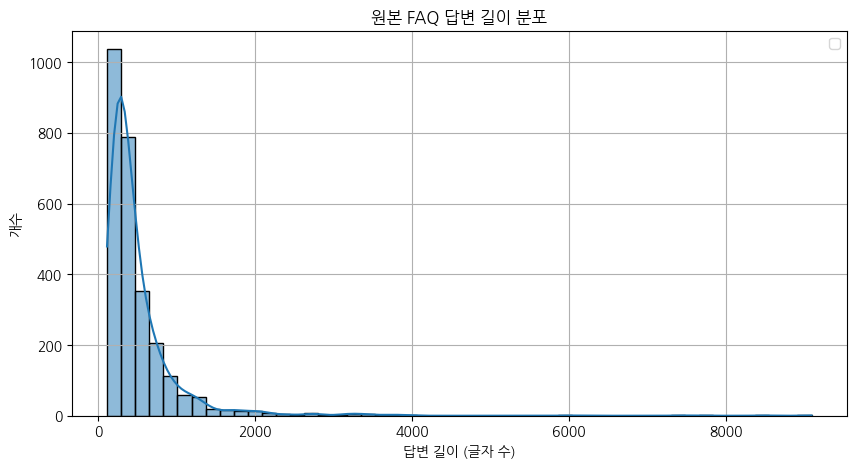

In [8]:
# 4.원본 FAQ 답변 길이 분포 시각화
original_lengths = [len(a) for a in raw_faq_data.values() if isinstance(a, str)]

plt.figure(figsize=(10, 5))
sns.histplot(original_lengths, bins=50, kde=True)
plt.title("원본 FAQ 답변 길이 분포")
plt.xlabel("답변 길이 (글자 수)")
plt.ylabel("개수")
plt.grid(True)
plt.legend()
plt.show()

🔎 인사이트/결과:
- raw_faq_data는 질문을 키로, 답변을 값으로 하는 딕셔너리 형태임을 확인
- 일부 답변 문자열에 "위 도움말이 도움이 되었나요?", "별점1점", "관련 도움말/키워드" 등과 같은 불필요한 푸터나 평가 문구가 포함되어 있음을 발견
- 이들은 실제 답변 내용이 아니므로, LLM의 학습에 방해가 되거나 답변의 불필요한 길이를 늘릴 수 있어 제거가 필요하다고 판단
- 간혹 답변이 문자열이 아닌 경우도 있을 수 있음을 확인하고, 이에 대한 예외 처리가 필요함을 인지

## 🧹 2. Footer 텍스트 전처리
- 전처리 대상 패턴 제거
  ➡️ FAQ 답변에서 핵심 내용만을 추출, LLM에게 정확하고 간결한 정보를 제공
- 전처리 전후 길이 비교

In [9]:
# 1.제거할 푸터 리스트 정의 (반복적인 패턴 파악)
footers_to_remove = [
    "위 도움말이 도움이 되었나요?", "별점1점", "별점2점", "별점3점", "별점4점", "별점5점",
    "소중한 의견을 남겨주시면 보완하도록 노력하겠습니다.",
    "보내기", "관련 도움말/키워드", "도움말 닫기"
]

In [10]:
cleaned_faq = {}
for question, answer in raw_faq_data.items():
    if not isinstance(answer, str): # 문자열이 아닌 경우 스킵
        print(f"⚠️ 경고: 질문 '{question}'의 답변이 문자열이 아닙니다. 스킵합니다.")
        continue

    processed_answer = answer
    # 2.각 푸터에 대해 답변을 분할하여 제거 시도
    for footer in footers_to_remove:
        if footer in processed_answer:
            processed_answer = processed_answer.split(footer, 1)[0] # 첫 번째 발견된 푸터까지만 사용

    # 3.추가적인 클리닝 (줄바꿈, 공백 제거)
    processed_answer = processed_answer.strip() # 양쪽 공백 제거
    processed_answer = processed_answer.replace("\n\n\n", "\n\n") # 3개 이상 연속된 줄바꿈을 2개로 축소 (가독성 유지)

    cleaned_faq[question] = processed_answer

👀 코드정리

❓ processed_answer.split(footer, 1)[0]
- 푸터가 답변의 끝 부분에 위치하는 패턴을 고려
- 답변 텍스트 내에서 특정 푸터가 발견되면 해당 푸터 이전의 내용만을 유효한 답변으로 간주하고 추출

❓ strip()과 replace("\n\n\n", "\n\n")
- 불필요한 공백과 과도한 줄바꿈을 정리
- 답변의 가독성을 높이고 임베딩 시 불필요한 노이즈를 줄임

In [11]:
# 5.클리닝 결과 샘플 확인
print("\n--- 푸터 제거 후 FAQ 데이터 샘플 ---")
for i, (q, a) in enumerate(cleaned_faq.items()):
    if i >= 3:
        break
    print(f"질문: {q}")
    print(f"클린된 답변: {a}...")
    print("-" * 30)


--- 푸터 제거 후 FAQ 데이터 샘플 ---
질문: [가입절차] 스마트스토어센터 회원가입은 어떻게 하나요? (ID만들기)
클린된 답변: 네이버 커머스 ID 하나로 스마트스토어센터와 같은 네이버의 다양한 커머스 서비스를 편리하게 이용하실 수 있습니다.네이버 커머스 ID가 없으시다면 [가입하기] 버튼을 통해 회원가입해 주세요.           1. '네이버ID' 로 네이버 커머스 ID 가입하기1) [네이버 아이디로 가입하기] 버튼을 눌러서 네이버 로그인 해 주세요.2) 연락가능한 휴대폰번호를 입력하시고 인증하신 후 개인정보 수집동의를 체크 하여 [가입] 버튼을 눌러주세요. 3) 네이버 커머스 ID 회원가입이 완료되어 해당 네이버ID 로 스마트스토어센터 서비스 가입을 하실 수 있습니다. 이 후 스마트스토어센터 로그인 시에 [네이버 아이디로 로그인] 버튼을 눌러서 네이버 로그인을 하실 수 있습니다. 2. '이메일 아이디'로 네이버 커머스 ID 가입하기 1) [이메일 아이디로 가입하기] 버튼을 눌러서 사용할 ID를 입력해 주세요.! 중요. 로그인 ID는 "실 사용중인 이메일주소"로 기재하셔야 합니다. (예 : abc@naver.com)2) 연락가능한 휴대폰번호와 이메일주소를 입력하시고 인증하신 후 개인정보 수집동의를 체크 하여 [가입] 버튼을 눌러주세요.3) 네이버 커머스 ID 회원가입이 완료되어 해당 이메일 아이디로 스마트스토어센터 서비스 가입을 하실 수 있습니다.이 후 스마트스토어센터 로그인 시에 해당 이메일 아이디와 비밀번호를 입력하여 로그인을 하실 수 있습니다. ※ 참고. 로그인 ID 계정 대표자와 사업자번호 대표자 동일여부는 체크하지 않습니다. (대표자가 상이해도 가입 진행 가능합니다.)...
------------------------------
질문: [가입서류] 스마트스토어 판매자 유형별 필요한 서류가 어떻게 되나요?
클린된 답변: 스마트스토어 판매 회원 분류는 아래와 같으며 반드시 모든 서류를 제출해 주셔야 가입이 가능합니다. 가입 서류는 가입 

In [12]:
# 6.푸터 제거 후 FAQ 답변 길이 추출
cleaned_lengths = [len(a) for a in cleaned_faq.values() if a] # 비어있는 답변 제외

In [13]:
# 7.길이 분포 통계 확인 (Pandas Series 활용)
length_series = pd.Series(cleaned_lengths)
print("\n--- 푸터 제거 후 FAQ 답변 길이 분포 (통계) ---")
print(length_series.describe(percentiles=[.25, .5, .75, .95]))


--- 푸터 제거 후 FAQ 답변 길이 분포 (통계) ---
count    2717.000000
mean      391.538462
std       538.628704
min         3.000000
25%       141.000000
50%       243.000000
75%       446.000000
95%      1123.600000
max      8996.000000
dtype: float64


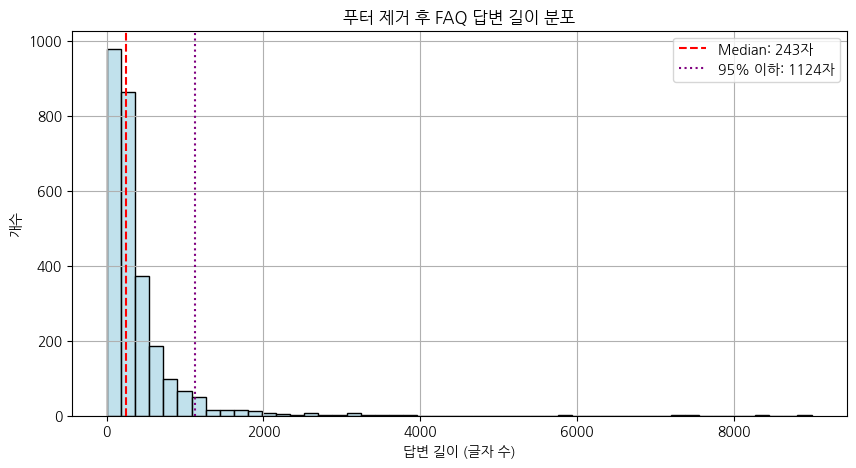

In [14]:
# 8.푸터 제거 후 FAQ 답변 길이 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_lengths, bins=50, color='lightblue', edgecolor='black')
plt.axvline(length_series.median(), color='red', linestyle='--', label=f'Median: {length_series.median():.0f}자')
plt.axvline(length_series.quantile(0.95), color='purple', linestyle=':', label=f'95% 이하: {length_series.quantile(0.95):.0f}자')
plt.title("푸터 제거 후 FAQ 답변 길이 분포")
plt.xlabel("답변 길이 (글자 수)")
plt.ylabel("개수")
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# 6. 원본과 클린된 답변 길이 비교
original_lengths = [len(a) for a in raw_faq_data.values() if isinstance(a, str)]
cleaned_lengths = [len(a) for a in cleaned_faq.values()]
print(f"\n원본 답변 평균 길이: {sum(original_lengths)/len(original_lengths):.2f}")
print(f"클린된 답변 평균 길이: {sum(cleaned_lengths)/len(cleaned_lengths):.2f}")


원본 답변 평균 길이: 501.69
클린된 답변 평균 길이: 391.54


🔎 인사이트/결과:

```
--- 푸터 제거 후 FAQ 답변 길이 분포 ---
count    2717.000000
mean      391.538462
std       538.628704
min         3.000000
25%       141.000000
50%       243.000000  # 중앙값 (Median)
75%       446.000000
95%      1123.600000 # 상위 5%를 제외한 답변의 최대 길이
max      8996.000000
dtype: float64
```
📌 통계 결과에서 mean (평균) 값이 합리적인 수준으로 줄었음 (푸터 제거의 효과)
- 그러나 std (표준편차) 값이 크고 max (최대) 값이 8996자로 매우 길다
- 히스토그램은 대부분의 답변이 짧은 길이(예: 500자 이내)에 집중되어 있으나 1000자를 넘는 답변들도 상당수 존재함

➡️ 푸터 제거를 통해 데이터가 정제되었으나 여전히 긴 답변이 존재

**📌 청킹이 필요한 이유:**
- GPT는 한 번에 많은 정보를 기억하지 못함
- 문서를 나누어 효율적으로 처리 가능
- 검색 정확도 및 환각 방지에 효과적


➡️ 청킹(Chunking) 전략 수립 필요

## ✂️ 3. 청킹(Chunking) 전략 결정
- 긴 FAQ 답변을 검색 및 LLM 처리에 적합한 크기로 분할하는 청킹 전략을 수립
- LLM의 토큰 제한에 맞춰 각 청크의 길이를 제어
- 검색 시 하나의 질문과 관련된 모든 정보가 한 청크에 담기지 않더라도, 인접한 청크를 통해 전체 맥락을 이해할 수 있도록
- 관련성 높은 청크가 검색될 가능성을 높이기
➡️ langchain의 `RecursiveCharacterTextSplitter`를 사용해 답변을 청크로 나누기




In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [17]:
# 1.RecursiveCharacterTextSplitter 초기화 및 파라미터 실험
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    add_start_index=True
)

👀 코드정리

❓ chunk_size=500
- 푸터 제거 후 답변 길이 통계(특히 75%, 95% 지점)를 고려하여 chunk_size를 결정
- 75% 답변 길이(446자)를 넘어서는 답변들이 청킹되도록 500자 설정

❓ chunk_overlap=100
- LLM의 토큰 제한(대략 1토큰 = 4글자)과 검색 효율성을 종합적으로 고려
- 청크 경계의 맥락 손실을 방지하기 위한 중복 설정

In [18]:
chunks, metas, ids = [], [], []
idx = 0
for q, a in cleaned_faq.items():
    pieces = splitter.split_text(a)
    for i, p in enumerate(pieces):
        chunks.append(p)
        metas.append({"original_question": q, "chunk_index": i + 1})
        ids.append(f"faq_{idx}")
        idx += 1

print(f"총 청크 수: {len(chunks)}")

총 청크 수: 3875


In [19]:
# 2. 생성된 청크 길이 분포 확인
chunk_lengths = [len(chunk) for chunk in chunks]
chunk_length_series = pd.Series(chunk_lengths)
print("\n--- 생성된 청크 길이 분포 (통계) ---")
print(chunk_length_series.describe(percentiles=[.25, .5, .75, .95]))


--- 생성된 청크 길이 분포 (통계) ---
count    3875.000000
mean      300.521548
std       157.409335
min         3.000000
25%       157.000000
50%       287.000000
75%       491.000000
95%       499.000000
max       500.000000
dtype: float64


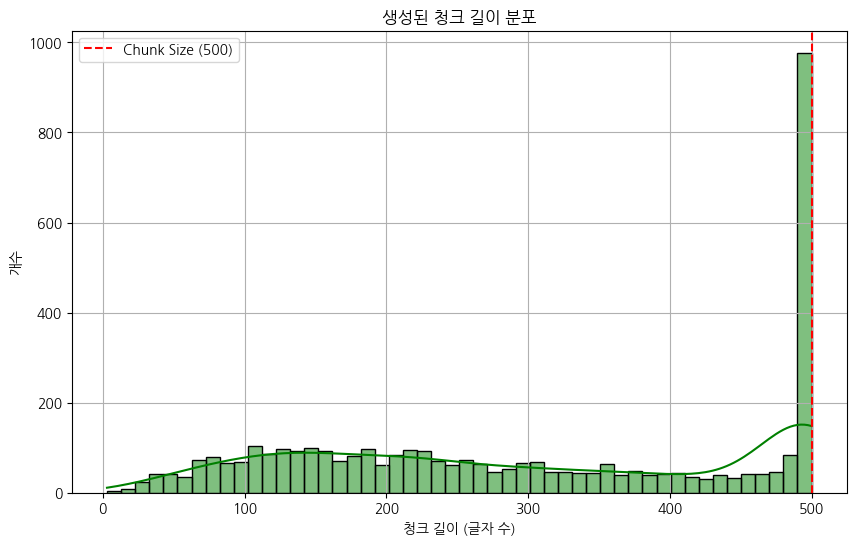

In [20]:
# 3. 청크 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(chunk_lengths, bins=50, kde=True, color='green')
plt.title("생성된 청크 길이 분포")
plt.xlabel("청크 길이 (글자 수)")
plt.ylabel("개수")
plt.axvline(x=500, color='r', linestyle='--', label='Chunk Size (500)')
plt.legend()
plt.grid(True)
plt.show()

🔎 인사이트/결과:

📌 RecursiveCharacterTextSplitter 선택
- 이 스플리터는 다양한 구분자를 사용하여 텍스트를 재귀적으로 분할
- 의미론적 경계를 최대한 존중하면서 청크를 생성하는 데 효과적이라고 판단

📌 chunk_size=500 설정
- 푸터 제거 후 답변 길이 통계에서 75%의 답변이 446자 이하
- 95%의 답변이 1123자
- 대부분의 짧은 답변은 하나의 청크로 유지
- 75%의 답변은 500자 이내(맥락 손실 방지)
- 긴 답변의 효율적인 분할
- 500자를 초과하는 긴 답변들은 여러 청크로 분할 ➡️ LLM의 토큰 제한을 준수, 검색 시 더 세밀한 정보 단위로 접근할 수 있음

📌 임베딩 및 검색 성능
- 너무 큰 청크는 임베딩 시 비효율적
- 관련 없는 정보를 포함할 확률을 높일 수 있음

📌 chunk_overlap=100 설정
- 각 청크가 이전 청크의 100자 정도를 포함하도록 설정
- 정보 손실을 최소화
- LLM이 답변을 생성할 때 더 완전한 맥락을 파악하여 전체적인 정보의 연속성을 유지

## 💾 4. 텍스트 임베딩 및 벡터 저장소 생성
📌 OpenAI 임베딩 모델 선택 (text-embedding-3-small)
- 텍스트 데이터를 고차원 벡터(임베딩)로 변환
- OpenAI의 최신 임베딩 모델 중 하나
- 효율적인 비용으로 높은 성능을 제공
- 대규모 텍스트 데이터를 처리하는 데 적합하다고 판단

📌 ChromaDB 클라이언트 설정
- 생성된 임베딩 벡터와 해당 텍스트 청크, 메타데이터를 저장하고 관리
- 저장된 벡터 데이터베이스에서 가장 유사한 FAQ 청크를 빠르게 검색

In [21]:
!pip install chromadb openai langchain tiktoken pandas matplotlib seaborn

In [22]:
from google.colab import userdata
import chromadb
from openai import OpenAI
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# 1.OpenAI 클라이언트 설정
api_key = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [24]:
# 2. ChromaDB 설정 (Google Drive 경로에 영구 저장)
chroma = chromadb.PersistentClient(path="/content/drive/MyDrive/FAQ_Project/chroma_db")

In [25]:
COLLECTION = "smartstore_faq_collection"

try:
    # 기존 컬렉션 삭제 후 생성 (populate_chroma.py의 목적과 동일)
    try:
        chroma.delete_collection(name=COLLECTION)
        print("기존 컬렉션 지웠어요.")
    except Exception as e:
        # 컬렉션이 없어서 삭제 실패하는 경우는 무시 (처음 실행 시 발생)
        print(f"기존 컬렉션이 없거나 삭제할 수 없습니다 (오류: {e}). 새로 생성합니다.")

    # 컬렉션을 생성하고 'col' 변수에 할당 (데이터 적재에 사용)
    col = chroma.create_collection(name=COLLECTION)
    print("ChromaDB 컬렉션 생성 완료.")
except Exception as e:
    print(f"ChromaDB 컬렉션 생성 실패: {e}")
    # exit() 대신 print만 하고 다음 셀로 넘어갈 수 있도록 수정
    print("ChromaDB 컬렉션이 없어 다음 단계 진행에 문제가 있을 수 있습니다.")
    col = None # 컬렉션 생성 실패 시 col을 None으로 설정

기존 컬렉션 지웠어요.
ChromaDB 컬렉션 생성 완료.


In [26]:
# 3. 텍스트 임베딩을 위한 모델 및 배치 처리 설정
model = "text-embedding-3-small"
embeddings = []
batch_size = 50

👀 코드정리

❓ text-embedding-3-small
- OpenAI의 효율적인 임베딩 모델
- 텍스트를 고차원 벡터로 변환

❓ batch_size
- API 호출 효율성을 위해 한 번에 처리할 청크의 개수를 지정

In [27]:
# 4. 임베딩 생성 및 ChromaDB에 청크 저장
for i in range(0, len(chunks), batch_size):
    try:
        batch = chunks[i:i + batch_size]
        res = client.embeddings.create(input=batch, model=model)
        embs = [x.embedding for x in res.data]
        embeddings.extend(embs)
        print(f"{i + len(embs)}개 임베딩 생성함!")
    except Exception as e:
        print(f"임베딩 실패: {e}")
        # 임베딩 실패 시 모든 진행을 멈추는 대신, 에러 메시지 출력 후 continue (다음 배치 시도)
        # 또는 'exit()'를 사용하여 강제 종료 가능 (디버깅 목적에 따라 선택)
        # exit()
        print("임베딩 생성 중 오류 발생, 다음 단계 진행에 문제가 있을 수 있습니다.")
        break # 임베딩 실패 시 루프 중단

if len(embeddings) != len(chunks):
    print("WARNING: 임베딩 수와 청크 수가 일치하지 않습니다. 뭔가 이상합니다.")
    # exit() # 문제 발견 시 종료 가능

print("ChromaDB에 청크 저장 중...")
# ChromaDB에 청크 저장
for i in range(0, len(chunks), batch_size):
    try:
        col.add( # 'col' 변수 사용
            documents=chunks[i:i + batch_size],
            embeddings=embeddings[i:i + batch_size],
            metadatas=metas[i:i + batch_size],
            ids=ids[i:i + batch_size]
        )
        print(f"{i + batch_size}개 저장됨!")
    except Exception as e:
        print(f"ChromaDB 저장 실패: {e}")
        # exit() # 문제 발견 시 종료 가능
        print("ChromaDB 저장 중 오류 발생, 데이터가 부분적으로 저장되었을 수 있습니다.")
        break # 저장 실패 시 루프 중단

print("\nChromaDB 데이터 적재 완료!")

50개 임베딩 생성함!
100개 임베딩 생성함!
150개 임베딩 생성함!
200개 임베딩 생성함!
250개 임베딩 생성함!
300개 임베딩 생성함!
350개 임베딩 생성함!
400개 임베딩 생성함!
450개 임베딩 생성함!
500개 임베딩 생성함!
550개 임베딩 생성함!
600개 임베딩 생성함!
650개 임베딩 생성함!
700개 임베딩 생성함!
750개 임베딩 생성함!
800개 임베딩 생성함!
850개 임베딩 생성함!
900개 임베딩 생성함!
950개 임베딩 생성함!
1000개 임베딩 생성함!
1050개 임베딩 생성함!
1100개 임베딩 생성함!
1150개 임베딩 생성함!
1200개 임베딩 생성함!
1250개 임베딩 생성함!
1300개 임베딩 생성함!
1350개 임베딩 생성함!
1400개 임베딩 생성함!
1450개 임베딩 생성함!
1500개 임베딩 생성함!
1550개 임베딩 생성함!
1600개 임베딩 생성함!
1650개 임베딩 생성함!
1700개 임베딩 생성함!
1750개 임베딩 생성함!
1800개 임베딩 생성함!
1850개 임베딩 생성함!
1900개 임베딩 생성함!
1950개 임베딩 생성함!
2000개 임베딩 생성함!
2050개 임베딩 생성함!
2100개 임베딩 생성함!
2150개 임베딩 생성함!
2200개 임베딩 생성함!
2250개 임베딩 생성함!
2300개 임베딩 생성함!
2350개 임베딩 생성함!
2400개 임베딩 생성함!
2450개 임베딩 생성함!
2500개 임베딩 생성함!
2550개 임베딩 생성함!
2600개 임베딩 생성함!
2650개 임베딩 생성함!
2700개 임베딩 생성함!
2750개 임베딩 생성함!
2800개 임베딩 생성함!
2850개 임베딩 생성함!
2900개 임베딩 생성함!
2950개 임베딩 생성함!
3000개 임베딩 생성함!
3050개 임베딩 생성함!
3100개 임베딩 생성함!
3150개 임베딩 생성함!
3200개 임베딩 생성함!
3250개 임베딩 생성함!
3300개 임베딩 생성함!
3350개 임베딩 생성함!
3400개 임베딩 생성함!


## 🧪 5. RAG 검색 시스템 성능 평가 및 SIMILARITY_THRESHOLD 최적화

In [28]:
# 1.검색 테스트 및 거리 값 분석
chroma_client_for_test = chromadb.PersistentClient(path="/content/drive/MyDrive/FAQ_Project/chroma_db")

try:
    faq_collection_for_test = chroma_client_for_test.get_collection(name=COLLECTION)
    print(f"ChromaDB 컬렉션 '{COLLECTION}' 연결 완료 (검색용).")
except Exception as e:
    print(f"ERROR: ChromaDB 컬렉션 '{COLLECTION}'을 찾을 수 없습니다. 이전 셀에서 데이터가 제대로 적재되었는지 확인하세요.")
    faq_collection_for_test = None

ChromaDB 컬렉션 'smartstore_faq_collection' 연결 완료 (검색용).


In [29]:
# 2. 테스트할 사용자 질문 리스트
test_queries = [
    "주문 취소는 어떻게 하나요?",
    "배송비가 얼마인가요?",
    "교환 및 반품 절차 알려주세요.",
    "스마트스토어 판매 수수료는 어떻게 되나요?",
    "제주도 특산품에 대해 알려주세요.", # 관련 없는 질문 예시
    "오늘 날씨 어때?", # 관련 없는 질문 예시
    "스마트스토어 계정 정지는 왜 되나요?",
    "상품 등록 방법 가이드 주세요"
]

In [30]:
# 3. ChromaDB 검색 실행 및 거리 값 수집
all_retrieved_distances = []

print("\n--- ChromaDB 검색 거리(Distance) 값 분석 ---")

if faq_collection_for_test: # 컬렉션이 제대로 연결된 경우에만 실행
    for i, query in enumerate(test_queries):
        # 너무 많은 쿼리로 인해 시간이 오래 걸릴 수 있으므로 5개만 테스트하도록 제한
        if i >= 5:
            print(f"\n(테스트 질문이 5개를 초과하여 중단합니다.)")
            break

        print(f"\n[질문 {i+1}: '{query}']")
        try:
            # 사용자 질문 임베딩 생성
            query_embed = client.embeddings.create(input=[query], model="text-embedding-3-small").data[0].embedding

            # ChromaDB 쿼리 실행: 가장 유사한 10개의 청크를 가져옴
            result = faq_collection_for_test.query(
                query_embeddings=[query_embed],
                n_results=10, # 충분한 결과를 보기 위해 10개로 설정
                include=["documents", "metadatas", "distances"]
            )

            # 검색 결과에서 거리, 문서, 메타데이터를 추출
            current_query_distances = result["distances"][0]
            current_query_docs = result["documents"][0]
            current_query_metas = result["metadatas"][0]

            # 각 검색 결과의 상세 정보를 출력하고 거리 값을 수집
            for j in range(len(current_query_distances)):
                dist = current_query_distances[j]
                doc = current_query_docs[j]
                meta = current_query_metas[j]
                original_question = meta.get('original_question', 'N/A')
                print(f"  - 거리: {dist:.4f}, 원본 질문: '{original_question[:30]}...', 내용: '{doc[:50]}...'")
                all_retrieved_distances.append(dist)

        except Exception as e:
            print(f"  오류 발생: {e}. 다음 질문으로 넘어갑니다.")
            continue # 하나의 쿼리 실패해도 다음 쿼리 진행

else:
    print("FAQ 컬렉션이 연결되지 않아 검색 테스트를 PASS합니다.")


--- ChromaDB 검색 거리(Distance) 값 분석 ---

[질문 1: '주문 취소는 어떻게 하나요?']
  - 거리: 0.6240, 원본 질문: '주문한 상품 중 일부만 취소할 수 있나요?...', 내용: '[판매관리 > 발주(주문)확인/발송관리]에서 상품별(상품주문번호)로 취소 가능합니다.단, ...'
  - 거리: 0.6256, 원본 질문: '취소 접수하였으나, 정상적으로 배송하고자 합니다 (온라...', 내용: '﻿구매자가 취소접수를 철회하면 이전 주문상태로 변경됩니다.구매자가 직접 취소를 철회하는 방...'
  - 거리: 0.6268, 원본 질문: '취소해야 하는데 구매자와 연락이 되지 않습니다. 어떻게...', 내용: '주문 취소 처리 시 "구매자에게 전할 말씀" 항목에 취소 사유를 기재해 주시면 구매자가 직...'
  - 거리: 0.6497, 원본 질문: '상품이 발송된 후 취소가 접수되면 어떻게 하나요? (온...', 내용: '취소요청된 주문이 이미 발송되어 취소 불가능한 상태라면 [판매관리 > 취소관리] 메뉴에서 ...'
  - 거리: 0.6571, 원본 질문: '취소 접수된 건 발송처리는 어떻게 하나요?...', 내용: '발송전 취소요청은 발주확인 후 발송처리 전에 구매자가 '주문 취소'를 요청한 건 입니다. ...'
  - 거리: 0.6584, 원본 질문: ''굿스플로 송장출력' 후 취소가 접수되면 어떻게 해야 ...', 내용: '굿스플로 송장출력한 경우 택배사에서 '집화'처리하면 '배송중' 상태로 변경됩니다.굿스플로 ...'
  - 거리: 0.6658, 원본 질문: '취소 접수는 어떻게 하나요? (온라인 교육 제공)...', 내용: '판매자가 [판매관리 > 발주(주문)확인/발송관리] 메뉴에서 취소처리하면 즉시 취소완료됩니다...'
  - 거리: 0.6680, 원본 질문: ''발송전 취소요청' 은 어떻게 해야 하나요?...', 내용: '발송전 취소요청은 발주확인 후 발송처리 전에 구매자가 '주문 취소'를 요청한 건 입니다. ..

In [31]:
# 4. 거리 값 통계 분석
distances_series = pd.Series(all_retrieved_distances)
print("\n--- 검색된 거리 값 통계 ---")
print(distances_series.describe(percentiles=[.1, .25, .5, .75, .9, .95]))


--- 검색된 거리 값 통계 ---
count    50.000000
mean      0.890358
std       0.164602
min       0.624038
10%       0.658303
25%       0.786987
50%       0.888497
75%       0.977385
90%       1.139141
95%       1.165514
max       1.193311
dtype: float64


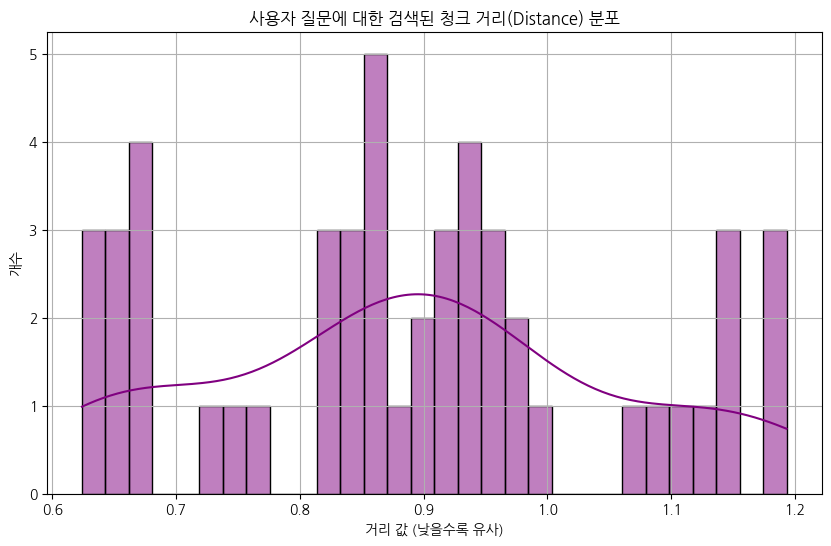

In [32]:
# 5. 모든 검색된 거리 값의 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(all_retrieved_distances, bins=30, kde=True, color='purple', edgecolor='black')
plt.title("사용자 질문에 대한 검색된 청크 거리(Distance) 분포")
plt.xlabel("거리 값 (낮을수록 유사)")
plt.ylabel("개수")
plt.grid(True)
plt.show()

🔎 인사이트/결과:
```
--- 검색된 거리 값 통계 ---
count    50.000000
mean      0.890020
std       0.163749
min       0.624038
10%       0.658225
25%       0.786519
50%       0.888514
75%       0.977147
90%       1.128881
95%       1.164577
max       1.193862
dtype: float64
```
📌 거리 값의 의미 확인
- ChromaDB에서 반환하는 distances 값은 **코사인 거리(Cosine Distance)**
- 즉, 0에 가까울수록 의미론적으로 매우 유사
- 값이 커질수록 유사도가 낮아져 2에 가까워질수록 완전히 비유사함을 의미

📌 평균 및 중앙값
- 검색된 거리의 평균(mean)이 약 0.89이고 중앙값(50%)이 약 0.88
- 대부분의 검색 결과가 1.0 미만의 값을 가짐
➡️ 해당 청크들이 질문과 높은 유사성을 가지고 있다

📌 상위 90% 이상의 분포
- 상위 10%에 해당하는 거리 값은 1.1을 넘어섬
➡️ 해당 청크들이 질문과 의미론적으로 거리가 멀다

📌 임계값이 너무 낮은 경우(예: 0.8 미만) ➡️ 챗봇의 **커버리지(Coverage)**를 저하
- 평균보다 훨씬 낮은 값을 설정하면 매우 유사한 정보만 포함
- LLM이 답변할 수 있는 범위가 좁아지거나
- 애매모호하게 다른 질문에는 답변하지 못할 위험이 있음

📌 임계값이 너무 높은 경우(예: 1.2 이상) ➡️ 챗봇의 **정확도(Accuracy)** 저하
- 관련성이 낮은 청크까지 LLM에 전달함
- LLM이 잘못된 정보를 기반으로 답변을 생성하거나 (환각, Hallucination)
- '해당 내용은 FAQ에서 찾을 수 없습니다.'와 같은 적절한 안내를 제공하지 못할 위험

## ✅ 6.최종 SIMILARITY_THRESHOLD를 1.1로 결정
📌 **90% 지점(1.128881)과 95% 지점(1.164577)**을 고려
- 1.1이라는 임계값은 대부분의 유효하고 관련성 높은 청크를 포함하면서도
- 질문과 **유사성이 현저히 떨어지는 청크들(상위 약 10% 내외)**을 효과적으로 필터링할 수 있는 경계선으로 판단

📌 검색 정확도와 답변 커버리지 사이의 합리적인 균형점을 찾는 데 1.1이 최적이라고 결론
- 이 임계값은 챗봇이 다양한 사용자 질문에 대해 적절한 수준의 커버리지를 유지, 불필요하거나 오해의 소지가 있는 정보의 유입을 최소화

## 📝 다음 단계에서 고려할 개선 방향
- Top-K 앙상블 검색 실험 예정
- GPT prompt 구성 및 응답 튜닝 전략 적용
- 다양한 도메인 FAQ 데이터셋 대응 실험 예정

### 📚 참고자료
- OpenAI Embedding API 문서: https://platform.openai.com/docs/guides/embeddings
- ChromaDB 공식: https://docs.trychroma.com/docs
- Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks(RAG 논문 (Lewis et al., 2020): https://velog.io/@tobigs-nlp/Retrieval-Augmented-Generation-for-Knowledge-Intensive-NLP-Tasks
- RAG가 적용된 나만의 챗봇 만들기(langchain, FastAPI, streamlit)
출처: https://issul.tistory.com/448: https://issul.tistory.com/448
- 챗봇 구축을 위한 RAG 시스템 구성 및 ChatGPT 연동 가이드: https://mori29.tistory.com/22#4.%20%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0%20%ED%8A%9C%EB%8B%9D-1-21
- RAG+LangChain : https://health-coding.tistory.com/93